In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/smoking")

print("Path to dataset files:", path)

100%|██████████| 63.8M/63.8M [00:00<00:00, 196MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5


In [3]:
fr_path = os.path.join(path,"Training","Training","*.jpg")

In [4]:
import glob
image_files = glob.glob(fr_path)
print(image_files[:5])

['/root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/smoking_0524.jpg', '/root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/smoking_0442.jpg', '/root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/notsmoking_0342.jpg', '/root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/notsmoking_0148.jpg', '/root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/notsmoking_0384.jpg']


In [5]:
from torchvision import transforms
transform = transforms.ToTensor()
image = Image.open(image_files[0])
image_tensor = transform(image)

# Show tensor shape
print(image_tensor.shape)

torch.Size([3, 250, 250])


In [6]:
for image_path in image_files[:5]:  # Check first 5 images
    img = Image.open(image_path)
    print(f"Image: {image_path}, Shape: {img.size}")

Image: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/smoking_0524.jpg, Shape: (250, 250)
Image: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/smoking_0442.jpg, Shape: (250, 250)
Image: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/notsmoking_0342.jpg, Shape: (250, 250)
Image: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/notsmoking_0148.jpg, Shape: (250, 250)
Image: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5/Training/Training/notsmoking_0384.jpg, Shape: (250, 250)


In [7]:
import os
import glob
from tqdm import tqdm

# Define dataset path
dataset_path = os.path.join(path, "Training", "Training")
# Get all image paths
train_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Validation", "Validation")
# Get all image paths
valid_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Testing", "Testing")
# Get all image paths
test_image_paths = glob.glob(f"{dataset_path}/*.jpg")


train_labels = []
valid_labels = []
test_labels = []

for path in tqdm(train_image_paths):
    prefix  = path.split("/")[-1].split("_")[0]                 # "./Training/smoking_0007.jpg" → "smoking_0007.jpg"  → "smoking"
    label = 1 if prefix == "smoking" else 0                     # Assign label
    train_labels.append(label)                                  # Store label

for path in tqdm(valid_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    valid_labels.append(label)

for path in tqdm(test_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    test_labels.append(label)

100%|██████████| 224/224 [00:00<00:00, 843378.90it/s]


In [8]:
from torch.utils.data import Dataset
from PIL import Image

class SmokingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get corresponding label

        # Load image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image and its label

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])


transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# Initialize datasets
train_dataset = SmokingDataset(train_image_paths, train_labels, transform=transform)
valid_dataset = SmokingDataset(valid_image_paths, valid_labels, transform=transform_valid_test)
test_dataset = SmokingDataset(test_image_paths, test_labels, transform=transform_valid_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0])


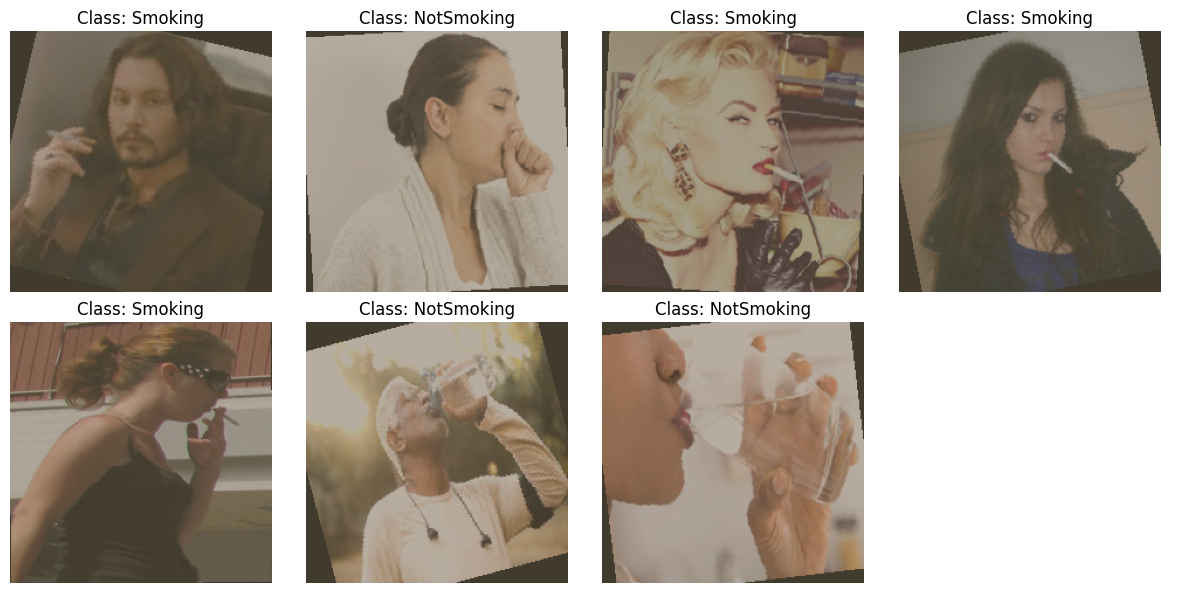

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Display 5 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

imgs_indices = [106,233,110,89,15,2,167]
axes = axes.flatten()
for i in range(7):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)


    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Show image
    axes[i].imshow(img_np)
    axes[i].set_title(f'Class: {"Smoking" if label == 1 else "NotSmoking"}')
    axes[i].axis('off')

axes[7].axis('off')
plt.tight_layout()
plt.show()

In [12]:
import torch
import torchvision.models as models
import torch.nn as nn

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained EfficientNetV2-S
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Modify the classifier head
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features=1280, out_features=1)  # 1 output neuron for binary classification
)

# Move model to GPU
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 115MB/s]


In [13]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        labels = labels.float()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track accuracy
        predictions = torch.sigmoid(outputs) > 0.5
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float()

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [14]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 23/23 [00:11<00:00,  1.92it/s]


Epoch 1/10: Train Loss=0.6340, Train Accuracy=65.36%, Val Loss=0.5402, Val Accuracy=85.56%


100%|██████████| 23/23 [00:10<00:00,  2.17it/s]


Epoch 2/10: Train Loss=0.4275, Train Accuracy=86.87%, Val Loss=0.3214, Val Accuracy=88.89%


100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch 3/10: Train Loss=0.2296, Train Accuracy=91.76%, Val Loss=0.1086, Val Accuracy=96.67%


100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


Epoch 4/10: Train Loss=0.1157, Train Accuracy=97.07%, Val Loss=0.0830, Val Accuracy=97.22%


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 5/10: Train Loss=0.0883, Train Accuracy=97.49%, Val Loss=0.0974, Val Accuracy=96.11%


100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch 6/10: Train Loss=0.0938, Train Accuracy=97.35%, Val Loss=0.0923, Val Accuracy=97.22%


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 7/10: Train Loss=0.0803, Train Accuracy=97.21%, Val Loss=0.0722, Val Accuracy=97.78%


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


Epoch 8/10: Train Loss=0.0570, Train Accuracy=98.32%, Val Loss=0.0940, Val Accuracy=97.22%


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


Epoch 9/10: Train Loss=0.0464, Train Accuracy=98.74%, Val Loss=0.0934, Val Accuracy=96.11%


100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch 10/10: Train Loss=0.0490, Train Accuracy=98.46%, Val Loss=0.1372, Val Accuracy=95.56%


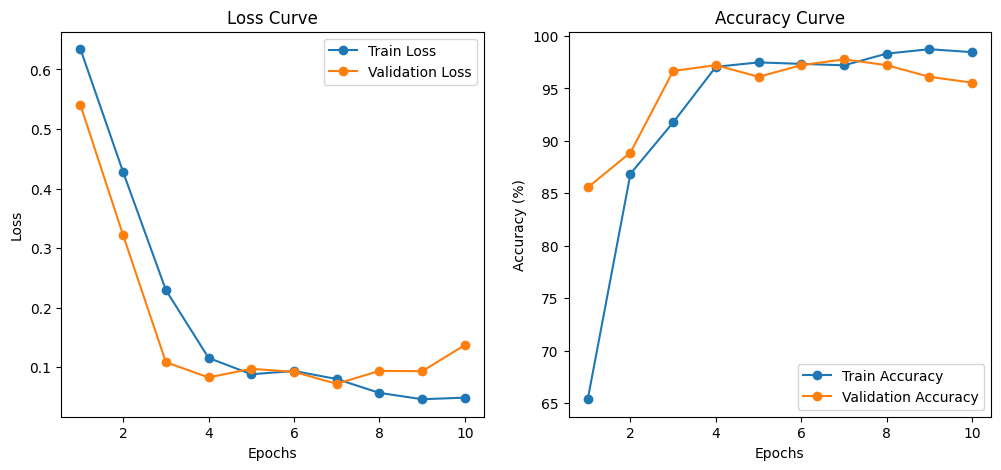

In [16]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


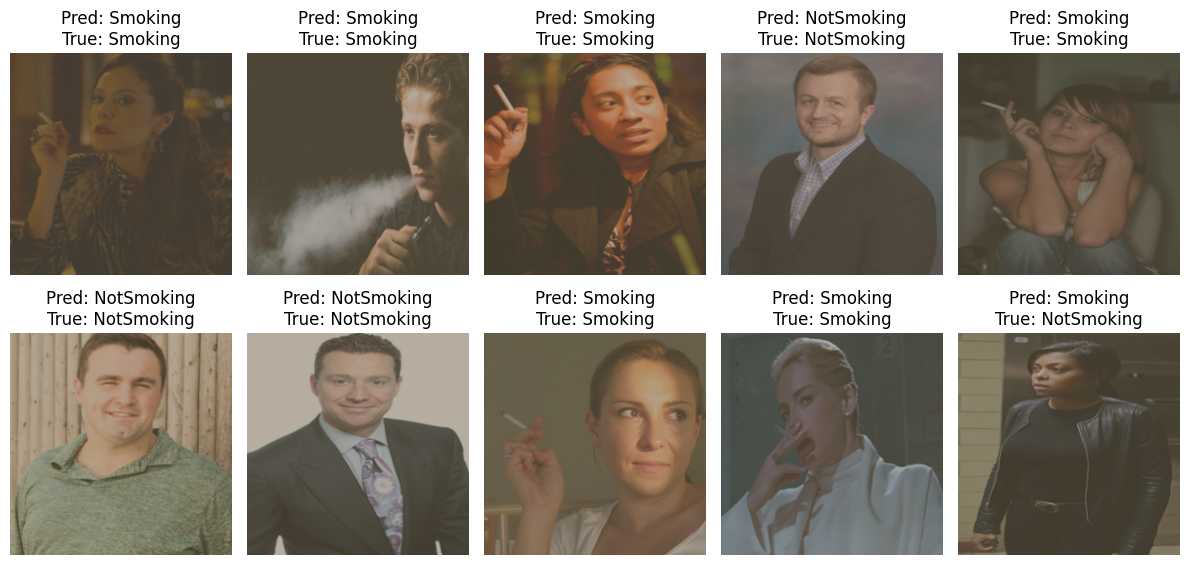

In [17]:
# Define class labels based on your dataset (1 for Smoking, 0 for NotSmoking)
class_names = ['NotSmoking', 'Smoking']  # This matches your dataset where 0 = NotSmoking and 1 = Smoking

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = torch.sigmoid(outputs).round().int()  # Sigmoid output for binary classification, round and cast to integer

    # Reverse normalization (if applied during training)
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
        img = img * std + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip to valid range

        # Ensure labels are integers
        pred_label = int(predictions[i].item())  # Predicted label (0 or 1)
        true_label = int(labels[i].item())  # True label (0 or 1)

        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(model, valid_loader, device)

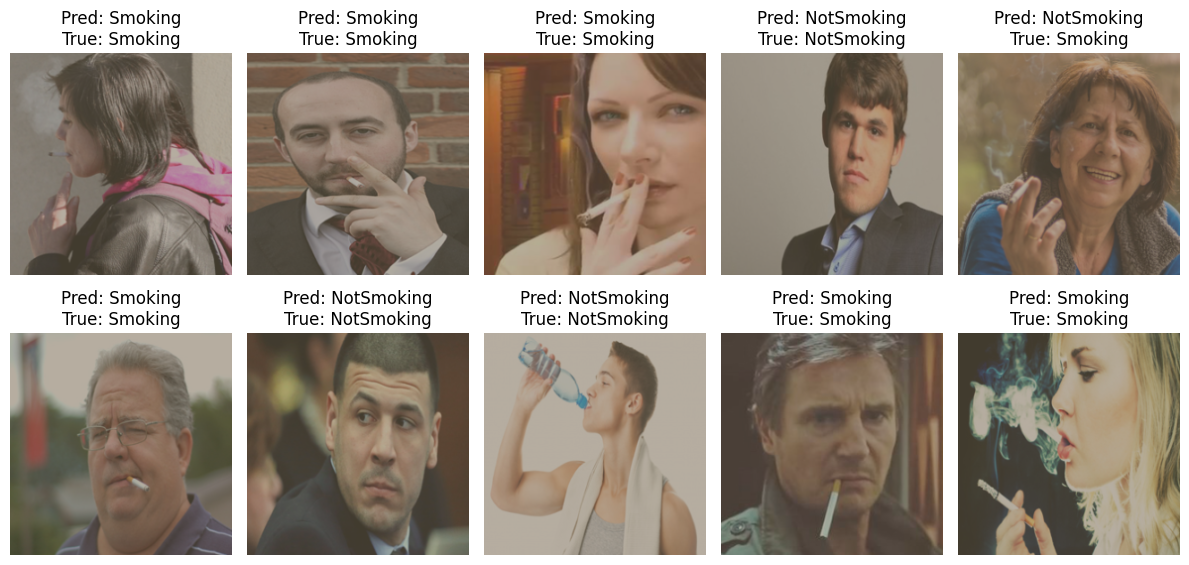

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Randomly select a batch
    batch_idx = random.randint(0, len(dataloader)-1)  # Select random index
    images, labels = list(dataloader)[batch_idx]  # Fetch random batch

    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = torch.sigmoid(outputs).round().int()  # Sigmoid output for binary classification, round and cast to integer

    # Define class labels
    class_names = ['NotSmoking', 'Smoking']

    # Reverse normalization (if applied during training)
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
        img = img * std + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip to valid range

        # Ensure labels are integers
        pred_label = int(predictions[i].item())  # Predicted label (0 or 1)
        true_label = int(labels[i].item())  # True label (0 or 1)

        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(model, valid_loader, device)
